In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage, misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


In [2]:
root_dir = '/home/ubuntu/pynb/SVHN'

In [3]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(path = root)
    tar.close()

maybe_extract(root_dir + '/data/train.tar.gz')
maybe_extract(root_dir + '/data/test.tar.gz')

/home/ubuntu/pynb/SVHN/data/train already present - Skipping extraction of /home/ubuntu/pynb/SVHN/data/train.tar.gz.
/home/ubuntu/pynb/SVHN/data/test already present - Skipping extraction of /home/ubuntu/pynb/SVHN/data/test.tar.gz.


TO DO: coverting from .mat to .csv

Read labels from csv files. How many examples do we have.

In [4]:
import csv
def read_csv(filename):
    with open(filename , 'rt') as f:
        reader = csv.reader(f)
        data_list = list(reader)
        
        d = {}
        for item in data_list:
            if not item[1].isdigit():
                continue
            if not item[0] in d:
                d[item[0]] = []
            d[item[0]].append([int(x) for x in item[1:]])
        return d, len(data_list)
    
def count_examples_by_digits(labels_dict):
    count = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    for x in labels_dict:
        count[len(labels_dict[x])] = count[len(labels_dict[x])] + 1
    count = {c: 100.0*count[c]/len(labels_dict) for c in count}
    return count
    
print (root_dir + '/data/train/trainData.csv')
labels_train_data_dict, training_digits = read_csv(root_dir + '/data/train/trainData.csv')
labels_test_data_dict, test_digits = read_csv(root_dir + '/data/test/testData.csv')
print ('Training dataset size ', len(labels_train_data_dict), ' with ',training_digits, ' digits.')
print ('Test datasset size ', len(labels_test_data_dict), ' with ',test_digits, ' digits.')

/home/ubuntu/pynb/SVHN/data/train/trainData.csv
Training dataset size  33402  with  73258  digits.
Test datasset size  13068  with  26033  digits.


What is the distribution of examples by number of digits in them?
First for the training set.

In [5]:
count_training = count_examples_by_digits(labels_train_data_dict)
for key in count_training:
    print (key, ' digit', count_training[key], '%')
plt.title('Examples(%) per number of digits in training set')
plt.xlabel('Number of digits')
plt.ylabel('Examples (%)')
plt.xticks(range(len(count_training)), count_training.keys())
plt.bar(range(len(count_training)), count_training.values(), align='center')
plt.show()

1  digit 15.379318603676426 %
2  digit 54.278186934914075 %
3  digit 26.019400035925994 %
4  digit 4.293156098437219 %
5  digit 0.02694449434165619 %
6  digit 0.0029938327046284655 %


We see that there are more than 50% two digit examples, and there are very few examples with more than 4 digits.
Let's plot the same graph for test dataset.

In [6]:
count_test = count_examples_by_digits(labels_test_data_dict)
for key in count_test:
    print (key, ' digit', count_test[key], '%')
plt.title('Examples(%) per number of digits in test set')
plt.xlabel('Number of digits')
plt.ylabel('Examples(%)')
plt.xticks(range(len(count_test)), count_test.keys())
plt.bar(range(len(count_training)), count_test.values(), align='center')
plt.show()

1  digit 19.000612182430363 %
2  digit 63.94245485154576 %
3  digit 15.924395469850015 %
4  digit 1.1172329354147537 %
5  digit 0.015304560759106214 %
6  digit 0.0 %


Set see that distribution is similar, with slightly more two digit numbers.

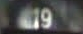

[[9, 41, 6, 12, 22], [7, 30, 7, 10, 22]]

In [7]:
from IPython.display import Image
display(Image(filename= root_dir + '/data/train/10855.png'))
labels_train_data_dict['10855.png']

In [8]:
import matplotlib.patches as patches
from PIL import Image

to_display = '13068.png'

im = np.array(Image.open(root_dir + '/data/train/' + to_display), dtype=np.uint8)
# Create figure and axes
fig,ax = plt.subplots(1)
# Display the image
ax.imshow(im)
print ('image shape:', im.shape)
for digit_loc in labels_train_data_dict[to_display]:
    # Create a Rectangle patch
    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
labels_train_data_dict[to_display].sort(key=lambda x: x[1])
print ([d[0] for d in labels_train_data_dict[to_display]])
print (labels_train_data_dict[to_display])
plt.show()

image shape: (83, 167, 3)
[1, 10]
[[1, 48, 9, 32, 67], [10, 82, 13, 33, 67]]


This function calculates minimum rectangle that contains all digits. 

In [9]:
def get_rectangle_containing_all_digits(digits):
    x = max(0, min([d[1] for d in digits]))
    y = max(0, min([d[2] for d in digits]))
    w = max([d[1] + d[3] - x for d in digits])
    h = max([d[2] + d[4] - y for d in digits])
    return x, y, w, h


Let's analyse cropped image sizes. This could be relevant to input image size to use in my model.

In [10]:
crop_size = {}
for image in os.listdir(root_dir + '/data/train/'):
    image_file = os.path.join(root_dir + '/data/train/', image)
    if not image.endswith('.png'):
        continue
    try:
        #image_orig = ndimage.imread(image_file, flatten=True)
        labels_train_data_dict[image].sort(key=lambda x: x[1])
        x, y, w, h = get_rectangle_containing_all_digits(labels_train_data_dict[image])
        croped_image_size = int((w*h)/100)
        if croped_image_size not in crop_size:
            crop_size[croped_image_size] = 0
        crop_size[croped_image_size] = crop_size[croped_image_size] + 1
    except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        
print ('Percentage of croped images with size less or equal to 2000 pixels ', 100.0*sum([v for k,v in crop_size.items() if k <= 20])/len(labels_train_data_dict))
print ('Percentage of croped images with size less or equal to 1500 pixels ', 100.0*sum([v for k,v in crop_size.items() if k <= 15])/len(labels_train_data_dict))
crop_size = {k:v for k,v in crop_size.items() if k <= 100}
plt.bar(list(crop_size.keys()), list(crop_size.values()), align='center')
plt.xlim(0, 100)
plt.title('Distibution of croped images by size (in 100s of pixels)')
plt.ylabel('Number of images')
plt.xlabel('Pixels (in 100s pixels)')
plt.show()

Percentage of croped images with size less or equal to 2000 pixels  76.49541943596192
Percentage of croped images with size less or equal to 1500 pixels  68.79528171965751


In [12]:
hight = 32
width = 64
image = misc.imread(root_dir + '/data/train/' + to_display)
print (image.shape)
print (get_rectangle_containing_all_digits(labels_train_data_dict[to_display]))
x, y, w, h = get_rectangle_containing_all_digits(labels_train_data_dict[to_display])
image = image[y: y+h, x: x+w]
print (image.shape)
image = misc.imresize(image, (hight, width))
plt.imshow(image)
plt.show()

(83, 167, 3)
(48, 9, 67, 71)
(71, 67, 3)


Resize pictures to 32*64 grayscale and save them into train.pickle and labels into labels_train.pickle.

In [13]:
def rescale(img, l, height, width):
    ph = float(img.shape[0])/height
    pw = float(img.shape[1])/width
    return [l[0], float(l[1])/ph, float(l[2])/pw, float(l[3])/pw, float(l[4])/ph]

In [14]:
pixel_depth = 255.0
hight = 32
width = 64

def save_to_pickle_file(set_filename, folder, labels, force = False):
    if os.path.exists(folder + set_filename) and not force:
        print ('Pickle file ', (folder + set_filename), 'already exists.')
        return
    image_files = os.listdir(root_dir + folder)
    d = dict()
    dataset = np.ndarray(shape=(len(image_files), hight, width), dtype=np.float32)
    num_images = 0
    for image in image_files:
        if not image.endswith('.png'):
            continue
        image_file = os.path.join(root_dir + folder, image)
        try:
            image_orig = ndimage.imread(image_file, flatten=True)
            labels[image].sort(key=lambda x: x[1])
            d[num_images] = [x[0] for x in labels[image]]
            x, y, w, h = get_rectangle_containing_all_digits(labels[image])
            #print (image_file , ':', image_orig.shape, ' -> ', x, y, w, h)
            image_orig = image_orig[y: y+h, x: x+w]
            image_data = (misc.imresize(image_orig, (hight, width)).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (hight, width):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    try:
        pickle.dump(dataset[0:num_images], open(root_dir + folder + set_filename, 'wb'), pickle.HIGHEST_PROTOCOL)
        print ((folder + set_filename), ' saved')
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
        
    try:
        file_name = "labels_" + set_filename
        pickle.dump(d, open( root_dir + folder + file_name, "wb" ))
        print ((folder + file_name), ' saved')
    except Exception as e:
        print('Unable to save data to', file_name, ':', e)
        

save_to_pickle_file('train.pickle', '/data/train/', labels_train_data_dict)
save_to_pickle_file('test.pickle',  '/data/test/', labels_test_data_dict)

/data/train/train.pickle  saved
/data/train/labels_train.pickle  saved
/data/test/test.pickle  saved
/data/test/labels_test.pickle  saved


In [15]:
train_data = pickle.load(open(root_dir + '/data/train/train.pickle', 'rb'))
print (train_data.shape)
labels_train_data = pickle.load(open(root_dir + '/data/train/labels_train.pickle', 'rb'))

test_data = pickle.load(open(root_dir + '/data/test/test.pickle', 'rb'))
print (test_data.shape)
labels_test_data = pickle.load(open(root_dir + '/data/test/labels_test.pickle', 'rb'))

(33402, 32, 64)
(13068, 32, 64)


In [15]:
# print (train_data[0]*pixel_depth+pixel_depth/2)
# print (labels_train_data[0])
index = 2
fig,ax = plt.subplots(1)
plt.imshow(train_data[index], interpolation='nearest')
print (labels_train_data[index])
#for digit_loc in labels_train_data[index]:
#    # Create a Rectangle patch
#    rect = patches.Rectangle((digit_loc[1],digit_loc[2]),digit_loc[3],digit_loc[4],linewidth=1,edgecolor='black',facecolor='none')
#    # Add the patch to the Axes
#    ax.add_patch(rect)
plt.show()


[1, 9, 1]


In [16]:
digits = 5
labels_train = np.zeros((len(labels_train_data), digits, 11))
labels_only = {x: [y%10 for y in labels_train_data[x]] for x in labels_train_data}
for x in labels_only:
    for i in range(digits-len(labels_only[x])):
        labels_train[x][i][10] = 1
    for i, y in enumerate(labels_only[x]):
        labels_train[x][digits-len(labels_only[x])+i][y] = 1 

index = 0
def get_train_examples(size):
    global index
    index += size
    if index >= train_data.shape[0]:
        index = 0
        return train_data[index-size: train_data.shape[0]], labels_train[index-size: train_data.shape[0]]
    return train_data[index-size:index], labels_train[index-size: index]

def get_test_examples(size, start = 0):
    labels_ = np.zeros((size+start, digits, 11))
    labels_only = {x: [y%10 for y in labels_test_data[x]] for x in labels_test_data}
    for x in range(start + size):
        for i in range(digits-len(labels_only[x])):
            labels_[x][i][10] = 1
        for i, y in enumerate(labels_only[x]):
            labels_[x][i+digits-len(labels_only[x])][y] = 1
    return test_data[start:start+size], labels_[start:start+size]
    

In [17]:
a, b = get_test_examples(1000)
print (b[0])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [18]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import math

import tensorflow as tf

FLAGS = None

pixel_depth = 255.0
hight = 32
width = 64

learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')

# Create the model
x = tf.placeholder(tf.float32, [None, hight, width], name='input') 
x_image = tf.reshape(x, [-1, hight, width, 1])

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 48])
b_conv1 = bias_variable([48])
  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_lrn1 = tf.nn.lrn(h_pool1)
  
## Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 48, 128])
b_conv2 = bias_variable([128])

h_conv2 = tf.nn.relu(conv2d(h_lrn1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_lrn2 = tf.nn.lrn(h_pool2)

## Third Convolutional Layer
W_conv3 = weight_variable([5, 5, 128, 192])
b_conv3 = bias_variable([192])

h_conv3 = tf.nn.relu(conv2d(h_lrn2, W_conv3) + b_conv3)
h_lrn3 = tf.nn.lrn(h_conv3)

## Forth Convolutional Layer
W_conv4 = weight_variable([3, 3, 192, 192])
b_conv4 = bias_variable([192])

h_conv4 = tf.nn.relu(conv2d(h_lrn3, W_conv4) + b_conv4)
h_lrn4 = tf.nn.lrn(h_conv4)

## Fifth Convolutional Layer
W_conv5 = weight_variable([3, 3, 192, 192])
b_conv5 = bias_variable([192])

h_conv5 = tf.nn.relu(conv2d(h_lrn4, W_conv5) + b_conv5)
h_lrn5 = tf.nn.lrn(h_conv5)

## Densely Connected Layer 1
W_fc1 = weight_variable([hight * width * 12, 2048])
b_fc1 = bias_variable([2048])

h_pool2_flat = tf.reshape(h_lrn5, [-1, hight * width * 12])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Densely Connected Layer 2
W_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## Readout Layer
W_fc3 = weight_variable([2048, 11*digits])
b_fc3 = bias_variable([11*digits])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
y_conv_r = tf.reshape(y_conv, [-1, digits, 11])

y = tf.placeholder(tf.float32, [None, digits, 11], name='output')
#y_r = tf.reshape(y, [-1, digits, 11])

cross_entropy = tf.reduce_mean(  math.pow(1.2, 0)*tf.nn.softmax_cross_entropy_with_logits(y_conv_r[0], y[0]) 
                               + math.pow(1.2, 1)*tf.nn.softmax_cross_entropy_with_logits(y_conv_r[1], y[1])
                               + math.pow(1.2, 2)*tf.nn.softmax_cross_entropy_with_logits(y_conv_r[2], y[2])
                               + math.pow(1.2, 3)*tf.nn.softmax_cross_entropy_with_logits(y_conv_r[3], y[3])
                               + math.pow(1.2, 4)*tf.nn.softmax_cross_entropy_with_logits(y_conv_r[4], y[4]))

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

accuracy_list = list()
loss_list = list()

correct_prediction = tf.equal(tf.argmax(y_conv_r, 2), tf.argmax(y, 2))
accuracy = tf.reduce_mean(tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1))

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(50001):
    batch_images, batch_labels = get_train_examples(50)
    lr = 1.0e-4
    loss = train_step.run(feed_dict={x: batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
    if i%100 == 0:
        batch_images, batch_labels = get_test_examples(2000)
        loss, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={x:batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: lr})
        print("step %d, training accuracy %g, loss %g"%(i, train_accuracy, loss))
        accuracy_list.append(train_accuracy)
        loss_list.append(loss)
        
test_imgs, test_labels = get_test_examples(2000)
print("test accuracy %g"% accuracy.eval(feed_dict={x: test_imgs, y: test_labels, keep_prob: 1.0, learning_rate: 0.0001}))

saver = tf.train.Saver()
save_path = saver.save(sess, root_dir + "/tmp/model.ckpt")
print("Model saved in file: %s" % save_path)


step 0, training accuracy 0.004, loss 128.369
step 100, training accuracy 0.011, loss 35.2186
step 200, training accuracy 0.016, loss 33.9467
step 300, training accuracy 0.026, loss 20.1758
step 400, training accuracy 0.026, loss 19.7637
step 500, training accuracy 0.054, loss 17.697
step 600, training accuracy 0.0435, loss 10.7357
step 700, training accuracy 0.015, loss 16.2858
step 800, training accuracy 0.0615, loss 15.3847
step 900, training accuracy 0.04, loss 13.2707
step 1000, training accuracy 0.0495, loss 14.1013
step 1100, training accuracy 0.0675, loss 15.1175
step 1200, training accuracy 0.0925, loss 12.7913
step 1300, training accuracy 0.0775, loss 9.37714
step 1400, training accuracy 0.073, loss 18.558
step 1500, training accuracy 0.101, loss 11.406
step 1600, training accuracy 0.11, loss 14.9212
step 1700, training accuracy 0.092, loss 19.5091
step 1800, training accuracy 0.083, loss 17.9322
step 1900, training accuracy 0.1205, loss 13.0193
step 2000, training accuracy 0

In [ ]:
from tensorflow.contrib.session_bundle import exporter

tensor_bindings = {"input": x,
                   "output": y,
                   "learning_rate": learning_rate,
                   "keep_prob": keep_prob}

signatures = { "classification": exporter.classification_signature(input_tensor=x, scores_tensor=y),
              "generic": exporter.generic_signature(tensor_bindings)}
export = exporter.Exporter(saver)
export.init(sess.graph.as_graph_def(), init_op = tf.initialize_all_variables(), named_graph_signatures=signatures)
export.export(root_dir + '/export', tf.constant(50001), sess)

In [ ]:
import tensorflow as tf

saver = tf.train.import_meta_graph(root_dir + '/tmp/model.ckpt.meta')
graph = tf.get_default_graph()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, root_dir + '/tmp/model.ckpt')
    batch_images, batch_labels = get_test_examples(2000)
    loss, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={x:batch_images, y: batch_labels, keep_prob: 1.0, learning_rate: 1.0e-4})
    print("step %d, training accuracy %g, loss %g"%(i, train_accuracy, loss))

In [ ]:
test_imgs, test_labels = get_test_examples(5000)
print("test accuracy %g"% accuracy.eval(feed_dict={x: test_imgs, y: test_labels, keep_prob: 1.0, learning_rate: 0.0001}))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(0, 10001, 100), accuracy_list, 'r')
plt.show()

In [ ]:
saver.restore(sess, root_dir + "/tmp/model.ckpt")
print ("Model restored.")

In [ ]:
def get_test_examples(size, start = 0):
    labels_ = np.zeros((size+start, 5, 11))
    labels_only = {x: [y%10 for y in labels_test_data[x]] for x in labels_test_data}
    for x in range(start + size):
        for i in range(5-len(labels_only[x])):
            labels_[x][i][10] = 1
        for i, y in enumerate(labels_only[x]):
            labels_[x][i+5-len(labels_only[x])][y] = 1
    return test_data[start:start+size], labels_[start:start+size]


def decode(output):
    result = ''
    for x in output:
        if x != 10:
            result = result + str(x)
    return result

test_imgs, test_labels = get_test_examples(1, 1)
# test_imgs, test_labels = get_train_examples(1)
plt.imshow(test_imgs[0], interpolation='nearest')
plt.show()
pred, acc = sess.run([y_conv, accuracy], feed_dict={x:test_imgs, keep_prob: 1.0, learning_rate: 0.0001, y: batch_labels})
print ('accuracy: ', acc)
#confidence = reduce(lambda x, y: x*y, [pred[i][x] for i, x in enumerate(np.argmax(pred, 1))])
#print ('confidence: ', confidence)
pred = tf.reshape(pred, (digits, 11))
pred = tf.nn.softmax(pred)
print (pred)
pred = tf.argmax(pred, 1)
print ('prediction : ', pred)
print ('correct : ', np.argmax(tf.reshape(test_labels, (digits, 11)).eval(), 1))
